In [1]:
import cobra
import pandas as pd
from cobra.flux_analysis import sample
import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_palette("coolwarm")

In [2]:
model_file = 'iCN900_09062018.json'
model = cobra.io.load_json_model(model_file)

## 1. Calculating flux distributions

In [3]:
# Sample the model:
import time
start = time.time()
s = sample(model, 1000)
end = time.time()
print(end-start)
s.to_csv('CDiff_sampled_1000.csv')

28.4520001411


In [4]:
# read in our sampled fluxes
s = pd.read_csv('CDiff_sampled_1000.csv',index_col=0)

3.33216080563
3.59972682368
3.36480995426


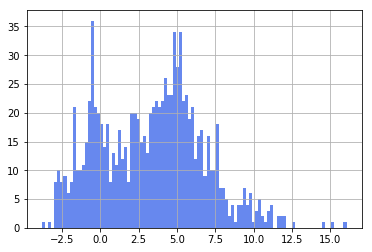

In [5]:
# show the flux distribution for Enolase ('ENO')
# Solution:


In [6]:
sampled_flux_medians = s.median().clip_upper(10).clip_lower(-10)

In [7]:
from escher import Builder
b = Builder(model=model,map_name="e_coli_core.Core metabolism",reaction_data=sampled_flux_medians.to_dict())
b.display_in_notebook()

## 2. Simple integration of transcriptomic data

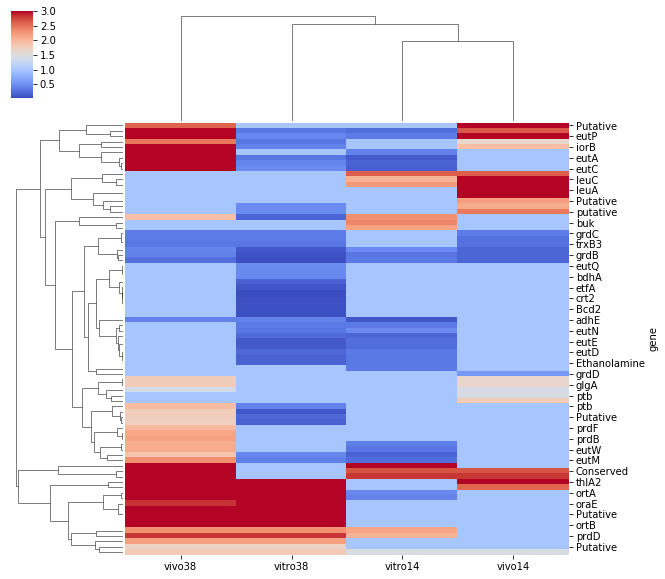

In [8]:
# gene expression data from:
# Adaptive Strategies and Pathogenesis of Clostridium difficile from In Vivo Transcriptomics by Janoir et al. I&I 2013
# doi: 10.1128/IAI.00515-13
data = pd.read_excel('expression.xlsx')
to_plot=data.copy()
to_plot.index=to_plot['gene']
to_plot = to_plot[['vitro14','vitro38','vivo14','vivo38']].clip_upper(3)
sns.clustermap(to_plot, cmap='coolwarm')

In [9]:
# note this data goes from vivo to vitro, so we need to convert for the reverse because we will be going from
# in-silico in vitro to invo cond:
data['to_adjust'] = data['vitro8']/data['vivo8']

In [10]:
data2 = data[data['to_adjust']!=1][['locus','to_adjust']]
data2

,locus,to_adjust
0,CD630_01120,2.29
1,CD630_01130,2.51
2,CD630_01140,2.15
4,CD630_01160,2.07
5,CD630_01170,2.44
6,CD630_01180,2.48
7,CD630_03340,0.43
34,CD630_19080,0.25
35,CD630_19090,0.32
36,CD630_19100,0.18


In [11]:
# adjust a gene (and its rxns) in one direction or another
def constrain_gene_flux(model, gene,factor):
    if gene in model.genes:
        reactions = model.genes.get_by_id(gene).reactions
        reaction_ids = [r.id for r in reactions]
        #print(s[reaction_ids].median())
        constrain = s[reaction_ids].median()
        for r in reactions:
            to_constrain = constrain.ix[r.id]*factor
            if to_constrain<0:
                r.lower_bound=to_constrain
            else:
                r.upper_bound=to_constrain
            print('adjusting %s (%s) from %s to %s'%(r.id, gene, to_constrain/factor, to_constrain))
    else:
        print('%s not in model'%gene)
    return model

In [12]:
sol=model.optimize()
print(sol.objective_value)

0.21028281212


In [13]:
for i in data2.index:
    gene = data2.loc[i,'locus']
    factor = data2.loc[i,'to_adjust']
    model = constrain_gene_flux(model, gene, factor)

adjusting PBUTT (CD630_01120) from -1.1813764346776254e-16 to -2.705352035411762e-16
adjusting PTA2E (CD630_01120) from 0.655524039442392 to 1.5011500503230777
adjusting PIBT (CD630_01120) from 0.3277815010666947 to 0.7506196374427309
adjusting BUTKr (CD630_01130) from -1.1813764346776254e-16 to -2.9652548510408397e-16
CD630_01140 not in model
adjusting VOR2bE (CD630_01160) from 0.08516080424529114 to 0.17628286478775265
CD630_01170 not in model
adjusting POR_syn (CD630_01180) from 0.17338740719983783 to 0.4300007698555978
adjusting BNOCA (CD630_03340) from 0.0 to 0.0
adjusting ALCD2x (CD630_03340) from -0.30415367930328685 to -0.13078608210041334
adjusting GLYCR (CD630_03340) from 0.012568814104141502 to 0.0054045900647808455
adjusting CHOLD2 (CD630_03340) from -5.234724094836257e-33 to -2.2509313607795902e-33
adjusting BTS_nadph (CD630_03340) from 0.0 to 0.0
adjusting IBHH (CD630_03340) from 0.3202609888608837 to 0.13771222521018
adjusting BTS (CD630_03340) from 0.0 to 0.0
adjusting 

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:9 DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [14]:
import time
start = time.time()
s2 = sample(model, 1000)
end = time.time()
print(end-start)
s2.to_csv('CDiff_adjust_sampled_1000.csv')

29.018999815


In [15]:
s2 = pd.read_csv('CDiff_adjust_sampled_1000.csv',index_col=0)

## 3. Comparing sampled flux states:

In [53]:
# use Kolmogorov-Smirnov statistic to check overlap of two distributions
from scipy import stats
import numpy as np

In [54]:
res = []
for r in model.reactions:
    p1 = s[r.id]
    p2 = s2[r.id]
    
    p1median = p1.median()
    p1mean = p1.mean()
    p1std = p1.std()
    
    p2median = p2.median()
    p2mean = p2.mean()
    p2std = p2.std()
    
    stat, pval = stats.ks_2samp(p1,p2)
      
    
    res.append({'reaction':r.id, 'p1median':p1median,'p1mean':p1mean, 'p1std':p1std, 
                'p2median':p2median,'p2mean':p2mean,'p2std':p2std, 'pval':pval})
res = pd.DataFrame(res)

In [55]:
res.to_csv('flux_differences.csv')

In [56]:
res = pd.read_csv('flux_differences.csv', index_col=0)

In [58]:
# Find significant changes and plot them on an Escher map:

#Soution:
